In [4]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from matplotlib.colors import to_rgba,to_rgb

In [5]:
def my_pinv(X,rank):
    U, Σ, Vh = np.linalg.svd(X,full_matrices=False)
    Σ[rank:] = 0.0
    return Vh.T.conj().dot(np.linalg.pinv(np.diag(Σ))).dot(U.T.conj())

def proj(X,y):
    return X - np.outer(X.dot(y.conj()),y)  / np.linalg.norm(y)**2

n=10,T=10,r=5


/usr/local/Cellar/python3/3.6.4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


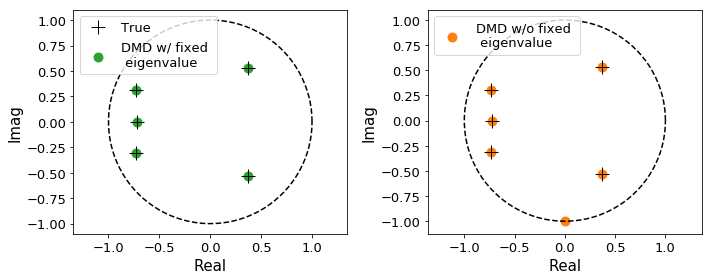

In [6]:
# Run all the DMD's
np.random.seed(9)
n_features = 10
T_time_steps = 10
num_eigenvals = 5

# Generate data
x0 = np.random.randn(n_features)  
rand_mat = np.random.randn(n_features,n_features) / np.sqrt(n_features) 
U,Σ,Vh = np.linalg.svd(rand_mat)
sig = np.zeros((n_features,n_features))
sig[range(num_eigenvals),range(num_eigenvals)] = Σ[:num_eigenvals] # Constrain 
A = U @ sig @ Vh
b =  np.random.randn(n_features) 

X = np.zeros((n_features,T_time_steps+1),dtype=complex)
X[:,0] = x0
for i in range(1,T_time_steps+1):
    X[:,i] = A @ X[:,i-1] + b
# We throw out the initial point so that all the data is in the range of A
# This enforces the fact that the number of nonzero eigenvalues of A is the rank of X_1
X = X[:,1:]


eigenvals,eigenvects = np.linalg.eig(A)

# Offset
b =  np.random.randn(n_features)

# Generate data
t = np.arange(T_time_steps)
X = np.zeros((n_features,T_time_steps+1),dtype=complex)
X[:,0] = x0
for i in range(1,T_time_steps+1):
    X[:,i] = A @ X[:,i-1] + b*(-1.0j)**i # Include term for eigenvalue -1.0j
X = X[:,1:]

# Using companion matrix
X1 = X[:,:-1]
X2 = X[:,1:]

# Noise level
σ = 0.0
X += np.random.randn(*X.shape)*σ

# Normal Solution (related to exactDMD)
normal_alg = {}
normal_alg['A'] = X2 @ my_pinv(X1,num_eigenvals+1)
normal_alg['label'] = 'DMD w/o fixed \n eigenvalue'
normal_alg['eig'] = np.linalg.eig(normal_alg['A'])[0]
normal_alg['nonzero_eig'] = normal_alg['eig'][np.abs(normal_alg['eig']) > 1e-12]
normal_alg['color'] = 'tab:orange'

# Mean subtraction with fixed eigenvalue
fixed_eig_alg = {}
res = proj(X1,(-1j)**np.arange(T_time_steps-1))
res2 = proj(X2,(-1j)**np.arange(1,T_time_steps))
fixed_eig_alg['A'] = res2.dot(my_pinv(res,num_eigenvals+1))
fixed_eig_alg['eig'] = np.linalg.eig(fixed_eig_alg['A'])[0]
fixed_eig_alg['nonzero_eig'] = fixed_eig_alg['eig'][np.abs(fixed_eig_alg['eig'])>1e-12]

# True eigenvalues
true_eig = np.linalg.eig(A)[0]
nonzero_true_eig = true_eig[np.logical_and(np.abs(true_eig)>1e-12,np.abs(true_eig-0.5+0.4j)>1e-12)]

print('n=' + str(n_features) + ',' + 'T=' + str(T_time_steps) + ',' + 'r=' + str(num_eigenvals))

# Plot 
plt.figure(figsize=(10,4))
plt.subplot(1,2,2)
plt.plot(np.real(nonzero_true_eig),np.imag(nonzero_true_eig),'k+',markersize=14)
plt.scatter(np.real(normal_alg['nonzero_eig']),np.imag(normal_alg['nonzero_eig']),
                label=normal_alg['label'],c=(*to_rgb('tab:orange'),1.0),
                s=80,edgecolors=(*to_rgb('tab:orange'),1.0))

plt.subplot(1,2,1)
plt.plot(np.real(nonzero_true_eig),np.imag(nonzero_true_eig),'k+',markersize=14,label='True')
plt.scatter(np.real(fixed_eig_alg['nonzero_eig']),np.imag(fixed_eig_alg['nonzero_eig']),
                    label='DMD w/ fixed \n eigenvalue',c=(*to_rgb('tab:green'),1.0),
                            s=80,edgecolors=(*to_rgb('tab:green'),1.0))

for _k in (1,2):
    plt.subplot(1,2,_k)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.ylabel('Imag',fontsize=15)
    plt.xlabel('Real',fontsize=15)
    temp = np.linspace(0,1,100)
    x = np.cos(2*np.pi*temp)
    y = np.sin(2*np.pi*temp)
    plt.plot(x,y, 'k--')
    plt.axis('equal')
    plt.legend(loc=2,fontsize=13)
plt.tight_layout()
plt.savefig('../Writeup/Figures/fixed_eig.png',dpi=300)